In [18]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from PIL import Image
import Helper

In [19]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

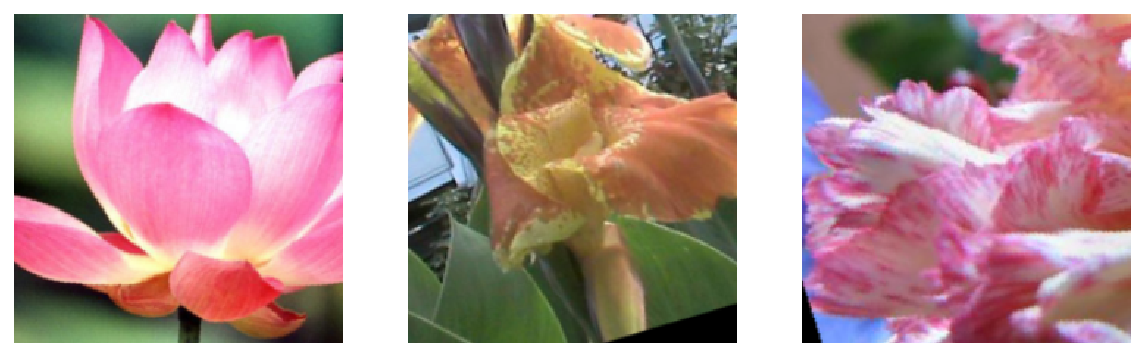

In [22]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms=
train_transforms=transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_data=datasets.ImageFolder(data_dir +'/train',transform=train_transforms)
test_data=datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
#data_loaders=
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=False)
validloader= torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

#A test to see if I am loading the images correctly


images, labels = next(iter(trainloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=3)
for i in range(3):
    ax = axes[i]
    Helper.imshow(images[i], ax=ax)

In [11]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [12]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
model.to('cuda')


from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu',nn.ReLU()),
                          ('drop',nn.Dropout(0.5)),
                          ('fc2',nn.Linear(4096,102)),
                          ('softmax',nn.LogSoftmax(dim=1))
    ]))
    
model.classifier = classifier
model
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)


In [13]:
# TODO: Do validation on the test set
#Defining validation loop
def validation_loop(model,testloader,criterion,):
    test_loss = 0
    accuracy = 0
    
    for images, (inputs,labels) in enumerate(testloader):
        images, labels = images.to('cuda'), labels.to('cuda')
                
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

print_every=32
steps =0
print("Initialize training .....\n")
epochs = 8

for e in range(epochs):
    running_loss = 0
    model.train() 
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
     
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(testloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()

print("\nTraining complete")

Initialize training .....



RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 4.00 GiB total capacity; 1.70 GiB already allocated; 603.14 MiB free; 2.10 GiB reserved in total by PyTorch)